## Traversing Functionally invariant path (FIP) to avoid catastrophic forgetting

FIP beginning from network trained on MNIST to ultimately discover a network that performs well on both (MNIST and Fashion-MNIST datasets)

In [1]:
## ALL IMPORTS

import numpy as np
import torch
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
#import seaborn as sns; sns.set()
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
from sklearn.utils.extmath import randomized_svd as rsvd
import h5py
import numpy.linalg as LA


In [2]:
torch.__version__

'1.3.1'

### Loading Train and Test loader for both the datasets (MNIST and Fashion-MNIST)

In [3]:
trainset_d1 =   torchvision.datasets.MNIST('MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

trainloader_d1 = torch.utils.data.DataLoader(trainset_d1, batch_size=4, shuffle=True)

testset_d1 = torchvision.datasets.MNIST('MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

testloader_d1 = torch.utils.data.DataLoader( testset_d1, batch_size=4, shuffle=True)

classes = ('0','1', '2', '3', '4','5', '6', '7', '8', '9')

In [4]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

# Use standard FashionMNIST dataset
trainset_d2 = torchvision.datasets.FashionMNIST(
    root = 'FashionMNIST/',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)


trainloader_d2 = torch.utils.data.DataLoader(trainset_d2, batch_size=100, shuffle=True)


testset_d2 = torchvision.datasets.FashionMNIST(
    root = 'FashionMNIST/',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

testloader_d2 = torch.utils.data.DataLoader( testset_d2, batch_size=100, shuffle=True)



In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Convolutional Network architecture 

(To learn both, MNIST and Fashion-MNIST datasets, while fed sequentially)

In [6]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=20)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

### Calculation of Train/Test accuracy on both datasets (MNIST / Fashion-MNIST)

In [7]:
def test_acc_dataset1(net):

    correct = 0;
    total = 0
    batch_size = 50;
    
    # shuffle dataset after every epoch
    #dataset1_idx = np.random.permutation(even_idx_test);

    running_loss = 0.0;
    batch_size = len(testset_d1);
    size_dataset = len(testset_d1)
    ctr_run = 0;
    for i in range(0, size_dataset, batch_size):

        image_input = torch.empty(batch_size,1,28,28)
        labels = torch.empty(batch_size);

        for j in range(batch_size):
            img, label = testset_d1[i+j]
            #img = img[0,:,:];
            #img = img.view(1,784)

            image_input[j,:,:,:] = img;
            labels[j] = label;

        outputs = net(image_input);
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test - dataset1 images: %d %%' % (
        100 * correct / total))
    return (100 * correct / total);

In [8]:
def test_acc_dataset2(net):

    correct = 0;
    total = 0
    batch_size = 50;
    
    # shuffle dataset after every epoch
    # dataset2_idx = np.random.permutation(odd_idx_test);

    running_loss = 0.0;
    batch_size = len(testset_d2);
    size_dataset = len(testset_d2)
    ctr_run = 0;
    for i in range(0, size_dataset, batch_size):

        image_input = torch.empty(batch_size,1,28,28)
        labels = torch.empty(batch_size);

        for j in range(batch_size):
            img, label = testset_d2[i+j]
            #img = img[0,:,:];
            #img = img.view(1,784)

            image_input[j,:,:,:] = img;
            labels[j] = label+10;

        outputs = net(image_input);
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on test - dataset2 images: %d %%' % (
        100 * correct / total))
    return (100 * correct / total);

In [9]:
def train_accuracy_dataset1(net):

    correct = 0;
    total = 0
    batch_size = 100;
    
    # shuffle dataset after every epoch
    # dataset1_idx = np.random.permutation(even_idx_train);

    running_loss = 0.0;
    batch_size = 4;
    size_dataset = len(trainset_d1)
    ctr_run = 0;
    for i in range(0, size_dataset, batch_size):

        image_input = torch.empty(batch_size,1,28,28)
        labels = torch.empty(batch_size);

        for j in range(batch_size):
            img, label = trainset_d1[i+j]
#             img = img.view(1,1,28,28)
#             img = img[0,:,:];
#             img = img.view(1,784)

            image_input[j,:,:,:] = img;
            labels[j] = label;

        outputs = net(image_input);
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train - dataset1 images: %d %%' % (
        100 * correct / total))
    return (100 * correct / total);

In [10]:
def train_accuracy_dataset2(net):

    correct = 0;
    total = 0
    batch_size = 100;
    
    # shuffle dataset after every epoch
    # dataset2_idx = np.random.permutation(odd_idx_train);

    running_loss = 0.0;
    batch_size = 4;
    size_dataset = len(trainset_d2)
    ctr_run = 0;
    for i in range(0, size_dataset, batch_size):

        image_input = torch.empty(batch_size,1,28,28)
        labels = torch.empty(batch_size);

        for j in range(batch_size):
            img, label = trainset_d2[i+j]
#             img.view(1,1,28,)
#             img = img[0,:,:];
#             img = img.view(1,784)

            image_input[j,:,:,:] = img;
            labels[j] = label;

        outputs = net(image_input);
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on train - dataset2 images: %d %%' % (
        100 * correct / total))
    return (100 * correct / total);

### Flatten convolutional networks to the weights space

In [11]:
def convertWtsVec2_network(wtsVec):

    trainAcc = [];
    testAcc = [];
    trainLossVal = []
    
    for numNetworks in range(1):
    
        #net3 = MLP_MNISTclasses();
        net3 = copy.deepcopy(net_MNIST)
        state_dict = net3.state_dict();

        ctr = 0;
        for n, p in state_dict.items():
            #print(p.shape)
            
            temp = p.view(-1,1);
            #temp = len(temp);
            
            val = wtsVec[ctr: ctr + len(temp)];
            #val = wtsDict[ctr][numNetworks];
            val = torch.Tensor(val).view(p.shape)

            if "weight" in n:
                for idx in range(val.shape[0]):
                    p[idx,:] = val[idx,:]
            else:
                for idx in range(val.shape[0]):
                    p[idx] = val[idx];

            ctr = ctr + len(temp)
        
    return net3


### Loss function for training network on image-classification task

In [12]:
### LOSS FUNCTION! ###
import torch.optim as optim
criterion = nn.CrossEntropyLoss();

### Function to train Convolutional network on the first dataset (MNIST) alone

In [13]:
def trainNetwork_dataset1(net, wtsDict, num_epochs=2):
    
    # Initial random network
    #storeWts_manifold2(net, wtsDict)
    pickle.dump(net, open("trainMNIST/CNN_train_MNIST_ep=0.p", "wb"))
    #acc_prev = train_accuracy_dataset1(net);
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    # size of dataset
    size_dataset = len(trainset_d1);
    
    for epoch in range(num_epochs):
        print("EPOCH = ", epoch)
        # shuffle dataset after every epoch
        # dataset1_idx = np.random.permutation(even_idx_train);
    
        running_loss = 0.0;
        batch_size = 4;

        ctr_run = 0;
        for i in range(0, size_dataset, batch_size):
                
            image_input = torch.empty(batch_size,1,28,28)
            labels = torch.empty(batch_size);

            for j in range(batch_size):
                img, label = trainset_d1[i+j]
                #img = img[0,:,:];
                #img = img.view(1,784)
    
                image_input[j,:,:,:] = img;
                labels[j] = label;

            output = net(image_input);
            loss = criterion(output, labels.long());
            
            # =====================backward==================
            optimizer.zero_grad()
            loss.backward()
            #plot_grad_flow(autoenc_ch.named_parameters)
            optimizer.step()
            
            #accVec.append(generalization_acc(net))
            #dist_hyper.append(0)
            running_loss += loss.item()
            if ctr_run % 2000 == 1999: # print every 8000 samples
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, ctr_run + 1, running_loss / 2000))
                #accVec.append(generalization_acc(net))
                #dist_hyper.append(0)
            
                running_loss = 0.0;
                
            ctr_run += 1;

        #acc = train_accuracy_dataset1(net);
        #epsilon = abs(acc_prev-acc)
        #if epsilon<0.01: # Covergence
            #storeWts_manifold2(net, wtsDict)
            #track_epoch.append(epoch+1)
         #   return (epoch+1, acc)
        #acc_prev = acc;
        test_acc_dataset1(net)
        #storeWts_manifold2(net, wtsDict)
        pickle.dump(net, open("trainMNIST/CNN_train_MNIST_ep="+str(epoch+1)+".p", "wb"))
                
    return (epoch+1, acc)
    

### Train randomly initialized CNN on the first dataset (MNIST) 

(Can be skipped if a trained MNIST network already exists in folder!)

In [17]:

net_MNIST = FashionCNN();


wtsDictionary_landscape = {};
ctr = 1;
for n,p in net_MNIST.named_parameters():
        
    temp = list(p.view(1,-1).size());
    wtsDictionary_landscape[ctr] = np.array([]).reshape(0,temp[1]);
    ctr += 1
    
net_train = copy.deepcopy(net_MNIST);
[returnTime, acc] = trainNetwork_dataset1(net_train, wtsDictionary_landscape, 10)





/home/graghava/.local/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


EPOCH =  0


KeyboardInterrupt: 

In [14]:
def calcWtsVec_fromNet(net):

    wtsVector_collection = np.array([])
    ctr = 0;
    idx = 0;
    state_dict = net.state_dict();
    for n, p in state_dict.items():
        
        wtsVec = p.view(-1,1);
        
        if (len(wtsVec) == 1 or '.running' in n):
            continue;
        
        #print(n, len(wtsVec), ctr)
        wtsVec = wtsVec.detach().numpy();
        wtsVector_collection = np.append( wtsVector_collection, wtsVec )
        #ctr = ctr + len(wtsVec);
    return wtsVector_collection

In [15]:
def convertWtsVec_network(wtsVec):

    for numNetworks in range(1):
    
        net3 = copy.deepcopy(net_MNIST)
        state_dict = net3.state_dict();

        ctr = 0;
        for n, p in state_dict.items():
            #print(p.shape)
            
            temp = p.view(-1,1);
            temp2 = list(p.size())
            #print(len(temp), n, len(temp2), ctr)
            
            if (len(temp) == 1 or '.running' in n):
                continue
            
            val = wtsVec[ctr: ctr + len(temp)];
            val = torch.Tensor(val).view(p.shape)
            
            if len(temp2) == 4:
                
                for idx in range(val.shape[0]):
                    p[idx,:,:,:] = val[idx,:,:,:]
                    
            elif len(temp2) == 2:
                
                for idx in range(val.shape[0]):
                    p[idx,:] = val[idx,:]
                    
            else:
                
                for idx in range(val.shape[0]):
                    p[idx] = val[idx];
                    
            ctr = ctr + len(temp)
            
    return net3
        

### New Optimizer for traversing the FIP

(optimized from optim.SGD)

In [16]:
import torch
import numpy as np
from torch.optim.optimizer import Optimizer, required
from scipy import linalg
import numpy.linalg as LA

class NGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).
    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf
    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.
        Considering the specific case of Momentum, the update can be written as
        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + g_{t+1}, \\
                p_{t+1} & = p_{t} - \text{lr} * v_{t+1},
            \end{aligned}
        where :math:`p`, :math:`g`, :math:`v` and :math:`\mu` denote the 
        parameters, gradient, velocity, and momentum respectively.
        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form
        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + \text{lr} * g_{t+1}, \\
                p_{t+1} & = p_{t} - v_{t+1}.
            \end{aligned}
        The Nesterov version is analogously modified.
    """

    
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(NGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(NGD, self).__setstate__(state)
        #print(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    
    def step(self, wts_sparse, lambda1, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        
        #lambda1 = 1;
        
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            
            # Find the gradient vector 
            gradVec = np.array([])
            wtsVec = np.array([])
            for p in group['params']:
                gVec = p.grad.view(-1,1);
                wVec = p.view(-1,1);
                gVec = gVec.detach().numpy()
                wVec = wVec.detach().numpy()
                
                gradVec = np.append(gradVec, gVec);
                wtsVec = np.append(wtsVec, wVec);
            
            #print('gradVec', gradVec); 
            if np.sum(np.isnan(gradVec))>0:
                print('gradVec', gradVec); 
            
                
            
            #print('gradVecLen', len(gradVec), len(wts_sparse), len(wtsVec))
            gradVec = gradVec + lambda1*(wtsVec-wts_sparse);
            tempVec = gradVec;
            #gradVec = gradVec/LA.norm(gradVec,2);
            #tempVec = gradVec - (lambda1*vec_hyperplane);
            
            #print(LA.norm(tempVec,2))
            update = tempVec;
            update = update/LA.norm(update,2);
            update = torch.Tensor(update);
            
            del gradVec
            
            
            ctr = 0;
            for p in group['params']:
            
                temp = len(p.view(-1,1));
                d_p = update[ctr:ctr+temp];
                d_p = d_p.view(p.shape);
                
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(d_p, alpha=-group['lr'])
                ctr = ctr + temp;

        return loss


In [19]:
def continualLearn(net, net_dataset2, manifold, wtsDict, num_epochs=2):
    
    # Initial random network
    #storeWts_manifold2(net, wtsDict)
    f_softmax = nn.Softmax(dim=1)
    ctr2 = 0;
    net_ori = copy.deepcopy(net);
    
    wts_net2 = calcWtsVec_fromNet(net_dataset2)
    wts_ori = calcWtsVec_fromNet(net)
    
    accVec = []
    dist_hyper = []
    
    data_prevTask = []
    batch_size = 50
    
    if manifold == 1:
        prevTrainset = trainset_d2
    else:
        prevTrainset = trainset_d1
    
    for ii in range(0,batch_size, batch_size):
    
        image_input = torch.empty(batch_size,1,28,28)
        labels = torch.empty(batch_size);

        for jj in range(batch_size):
            img, label = prevTrainset[ii+jj]
            #img = img[0,:,:];
            #img = img.view(1,784)

            image_input[jj,:,:,:] = img;

        data_prevTask.append(image_input)
    
    
#     accVec.append([test_acc_dataset1(net),test_acc_dataset2(net)]);
#     #accVec.append(generalization_acc(net));
#     dist_hyper.append(LA.norm(wts_net2 - wts_ori,2))
    
    #opt1 = NGD(net.parameters(), lr=0.1)
    opt1 = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    lambda1 = 2;
    
    if manifold == 1:
        trainset = trainset_d1;
    else:
        trainset = trainset_d2;
    
    
    for epoch in range(num_epochs):

        running_loss = 0.0;
        batch_size = 100;

        ctr_run = 0;
        #wts_curr = calcWtsVec_fromNet(net);
        #_, wts_sparse = findVec_sparseHyperplane(net, sparsity)
        
        for i in range(0, 60000, batch_size):
                
            image_input = torch.empty(batch_size,1,28,28)
            labels = torch.empty(batch_size);

            for j in range(batch_size):
                img, label = trainset[i+j]
                #img = img[0,:,:];
                #img = img.view(1,784)
                
                image_input[j,:,:,:] = img;
                
                if manifold == 1:
                    labels[j] = label;
                else:
                    labels[j] = label+10
                    
                    
            output = net(image_input);
            CEloss = criterion(output, labels.long());
            
            output_ori = f_softmax(net_ori(image_input));
            
            output_d2 = f_softmax(net(data_prevTask[0]));
            output_newDest = f_softmax(net_dataset2(data_prevTask[0]))
            
            output_ori = output_ori.detach()
            output_newDest = output_newDest.detach()
            #loss = torch.sum(torch.sum(torch.sqrt(output*output_ori+0.01), axis=1))
            epsAdd = max(1e-10, torch.min(output_ori)*1e-3);
            loss1 = torch.sum(-torch.log(torch.sum(torch.sqrt(output*output_ori+epsAdd), axis=1)));
            loss2 = torch.sum(-torch.log(torch.sum(torch.sqrt(output_d2*output_newDest+epsAdd), axis=1)));
            
            loss = CEloss + loss2
            #print(loss, torch.min(output_ori))
            #loss = criterion(output, labels.long())
            #_, wts_sparse = findVec_sparseHyperplane(net, sparsity)

            # =====================backward==================
            opt1.zero_grad()
            loss.backward()
            opt1.step()
            #plot_grad_flow(autoenc_ch.named_parameters)
            #opt1.step(wts_net2, lambda1)
            
            
            if ctr_run % 100 == 0:
                ctr2 +=1
                #storeWts_manifold2(net, wtsDict)
                
                wts_inter = calcWtsVec_fromNet(net);                
                #_, wts_fin = findVec_sparseHyperplane(net, sparsity)                
                accVec.append([test_acc_dataset1(net),test_acc_dataset2(net)]);
                #accVec.append(generalization_acc(net));
                dist_hyper.append(LA.norm(wts_net2 - wts_inter,2))
                
                print('Distance from net2', dist_hyper[-1])
                print('Accuracy', accVec[-1])
                #pickle.dump([accVec, dist_hyper, net], open("CNN_MNIST2FMNIST_BH_batchsize=100.p", "wb"))
                
                folderName = 'geo_MtoF2/'
                fileName = 'net='+str(ctr2)+".p"
                fname = folderName + fileName
                
                pickle.dump([accVec, dist_hyper, net], open(fname, "wb"))
                print("Loss val", loss)
                if dist_hyper[-1]<0.01:
                    break
            
            #accVec.append(generalization_acc(net))
            #dist_hyper.append(0)
            running_loss += loss.item()
            if ctr_run % 2000 == 1999: # print every 8000 samples
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, ctr_run + 1, running_loss / 2000))
                #accVec.append(generalization_acc(net))
                #dist_hyper.append(0)
            
                running_loss = 0.0;
                
            ctr_run += 1;

    return (accVec, dist_hyper)
    

In [20]:
#[net_d1, net_d2] = pickle.load(open("CNN_trainNEW_MNIST_FMNIST.p", "rb"))
net_train = pickle.load(open("trainMNIST/CNN_train_MNIST_ep=10.p", "rb"))
net_d1 = copy.deepcopy(net_train)
#net_d2 = copy.deepcopy(net_FMNIST)

manifold = 2;

num_epochs = 50
[accVec, dist_hyper] = continualLearn(net_d1, net_d1, manifold, {}, num_epochs)

Accuracy of the network on the test - dataset1 images: 98 %
Accuracy of the network on test - dataset2 images: 0 %
Distance from net2 0.017394160385978498
Accuracy [98.68, 0.0]
Loss val tensor(10.7467, grad_fn=<AddBackward0>)
Accuracy of the network on the test - dataset1 images: 96 %
Accuracy of the network on test - dataset2 images: 71 %
Distance from net2 1.8397043652694949
Accuracy [96.94, 71.09]
Loss val tensor(0.8630, grad_fn=<AddBackward0>)
Accuracy of the network on the test - dataset1 images: 96 %
Accuracy of the network on test - dataset2 images: 73 %
Distance from net2 2.054774662662631
Accuracy [96.41, 73.89]
Loss val tensor(0.6543, grad_fn=<AddBackward0>)
Accuracy of the network on the test - dataset1 images: 95 %
Accuracy of the network on test - dataset2 images: 75 %
Distance from net2 2.18833232936498
Accuracy [95.93, 75.97]
Loss val tensor(0.6077, grad_fn=<AddBackward0>)
Accuracy of the network on the test - dataset1 images: 95 %
Accuracy of the network on test - datas

KeyboardInterrupt: 

### Figures to capture performance of networks along FIP 

(on the held-out dataset (test accuracy) on both MNIST and Fashion-MNIST datasets)

### Get Networks along the Traditional fine-tuning paradigm 

In [23]:
list_nets_traditional = [];

for ctr_run in range(0,10,2):
    net = pickle.load(open("trainMNIST/CNN_train_MNIST_ep="+str(ctr_run)+".p", "rb"))
    list_nets_traditional.append(net)

    
for ctr_run in range(0,200,20):
    net = pickle.load(open("trainFMNIST/CNN_train_FMNIST_ctr="+str(ctr_run)+".p", "rb"))
    list_nets_traditional.append(net[0])
    

### Get networks along the FIP 

In [27]:
list_nets_geo = []

for ctr_run in range(0,10,2):
    net = pickle.load(open("trainMNIST/CNN_train_MNIST_ep="+str(ctr_run)+".p", "rb"))
    list_nets_geo.append(net)


for ctr_run in range(1,100,10):
    acc, dist, net = pickle.load(open("geo_MtoF2/net="+str(ctr_run)+".p", "rb"))
    list_nets_geo.append(net)

### Generating Performance Heatmap of networks obtained along (i) traditional fine-tuning and (ii) traversing the FIP 

(on MNIST and Fashion-MNIST datasets)

In [61]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})



def constructHeatmap(list2):
    
    classes_d1 = ('0','1', '2', '3', '4','5', '6', '7', '8', '9')
    classes_d2 = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

    batch_size = 100;

    f_softmax = nn.Softmax(dim=1)

    for net_id in range(0,15,1):

        network = list2[net_id]
        #network = list_net_mid[net_id]

        for i in range(0, batch_size, batch_size):

            imgs = torch.empty(batch_size,1,28,28)
            targets = torch.empty(batch_size);

            trainset = trainset_d1
            classes = classes_d1

            for j in range(batch_size):
                img, label = trainset[i+j]
                #img = img[0,:,:];
                #img = img.view(1,784)
                #print(img.shape)
                imgs[j,:,:,:] = img;
                targets[j] = label;

            outputs = f_softmax(network(imgs));

            probVal = []
            for ii in range(batch_size):
                probVal.append(outputs[ii][targets[ii].long().item()].item())

            probVal = np.array(probVal)
            _, predicted = torch.max(outputs.data,1)

            s1 = predicted==targets.long()
            s1 = s1*1
            #list_mnist_perf.append(s)
            #print(s.numpy())

        for i in range(0, batch_size, batch_size):

            imgs = torch.empty(batch_size,1,28,28)
            targets = torch.empty(batch_size);

            trainset = trainset_d2
            classes = classes_d2

            for j in range(batch_size):
                img, label = trainset[i+j]
                #img = img[0,:,:];
                #img = img.view(1,784)
                #print(img.shape)
                imgs[j,:,:,:] = img;
                targets[j] = label+10;

            outputs = f_softmax(network(imgs));

            probVal2 = []
            for ii in range(batch_size):
                probVal2.append(outputs[ii][targets[ii].long().item()].item())

            probVal2 = np.array(probVal2)

            _, predicted = torch.max(outputs.data,1)

            s2 = predicted==targets.long()
            s2 = s2*1

        concat = np.concatenate((probVal,probVal2), axis=0)
        concat2 = np.concatenate((s1,s2), axis=0)
        
        if net_id == 0:
            heatmap = np.reshape(concat, [len(concat),1])
            heatmap_acc = np.reshape(concat2, [len(concat2),1])
        else:
            heatmap = np.append(heatmap, np.reshape(concat, [len(concat),1]),axis=1)
            heatmap_acc = np.append(heatmap_acc, np.reshape(concat2, [len(concat2),1]),axis=1)


    heatmap = heatmap.T  
    heatmap_acc = heatmap_acc.T
    
    return heatmap, heatmap_acc

### Heatmap for traditional fine-tuning

In [72]:
heatmap, heatmap_acc = constructHeatmap(list_nets_traditional)

mnist_idx = list(range(0,int(heatmap.shape[1]/2)))
fmnist_idx = list(range(int(heatmap.shape[1]/2),int(heatmap.shape[1])))


a1 = np.argsort(np.sum(heatmap[:,mnist_idx],0))
a2 = np.argsort(np.sum(heatmap[:,fmnist_idx],0))

heatmap2_m = copy.deepcopy(heatmap[:,mnist_idx])
heatmap2_f = copy.deepcopy(heatmap[:,fmnist_idx])

heatmap2_m = heatmap2_m[:,a1]
heatmap2_f = heatmap2_f[:,a2]

heatmap2 = np.concatenate((heatmap2_m, heatmap2_f),axis=1)

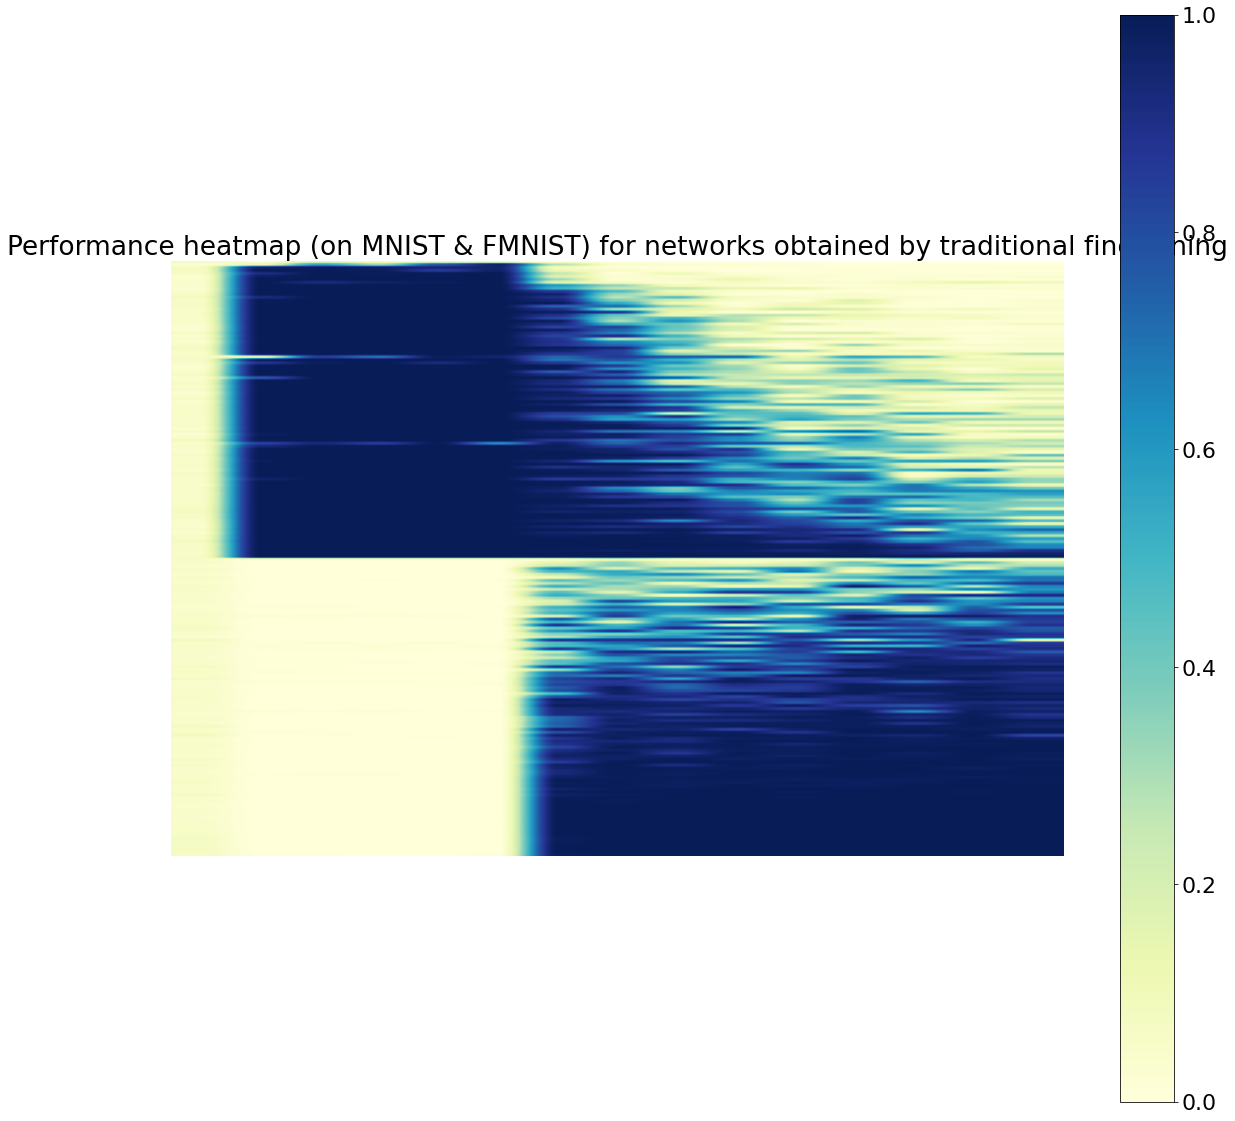

In [73]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from cmcrameri import cm

data = heatmap2
image = np.array(data.T)
nrows, ncols = image.shape

fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(image, cmap='YlGnBu', aspect=0.05)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.05)
#ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.1)

plt.colorbar()
plt.axis('off')
plt.title('Performance heatmap (on MNIST & FMNIST) for networks obtained by traditional fine-tuning')
#plt.savefig('Heatmap_continual_CF_conv.svg', format='svg')
plt.show()

### Plot of accuracy of networks obtained along traditional fine-tuning
(on MNIST and Fashion-MNIST datasets)

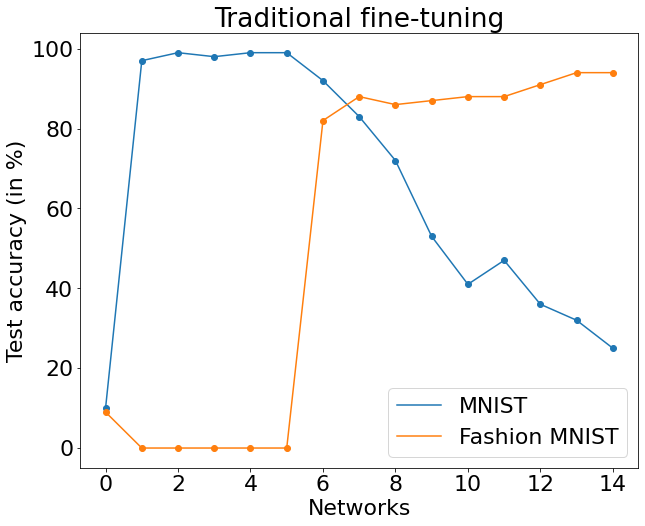

In [74]:
fig = plt.figure(figsize=(10,8))
mnist_acc = np.sum(heatmap_acc[:,mnist_idx],1)/100*100
fmnist_acc = np.sum(heatmap_acc[:,fmnist_idx],1)/100*100

plt.plot(mnist_acc, label="MNIST")
plt.plot(fmnist_acc, label="Fashion MNIST")
plt.scatter(list(range(len(mnist_acc))),mnist_acc)
plt.scatter(list(range(len(fmnist_acc))),fmnist_acc)

plt.title("Traditional fine-tuning")
plt.xlabel("Networks")
plt.ylabel("Test accuracy (in %)")
plt.legend()

### Heatmap for networks along FIP

In [64]:
heatmap, heatmap_acc = constructHeatmap(list_nets_geo)

mnist_idx = list(range(0,int(heatmap.shape[1]/2)))
fmnist_idx = list(range(int(heatmap.shape[1]/2),int(heatmap.shape[1])))


a1 = np.argsort(np.sum(heatmap[:,mnist_idx],0))
a2 = np.argsort(np.sum(heatmap[:,fmnist_idx],0))

heatmap2_m = copy.deepcopy(heatmap[:,mnist_idx])
heatmap2_f = copy.deepcopy(heatmap[:,fmnist_idx])

heatmap2_m = heatmap2_m[:,a1]
heatmap2_f = heatmap2_f[:,a2]

heatmap2 = np.concatenate((heatmap2_m, heatmap2_f),axis=1)


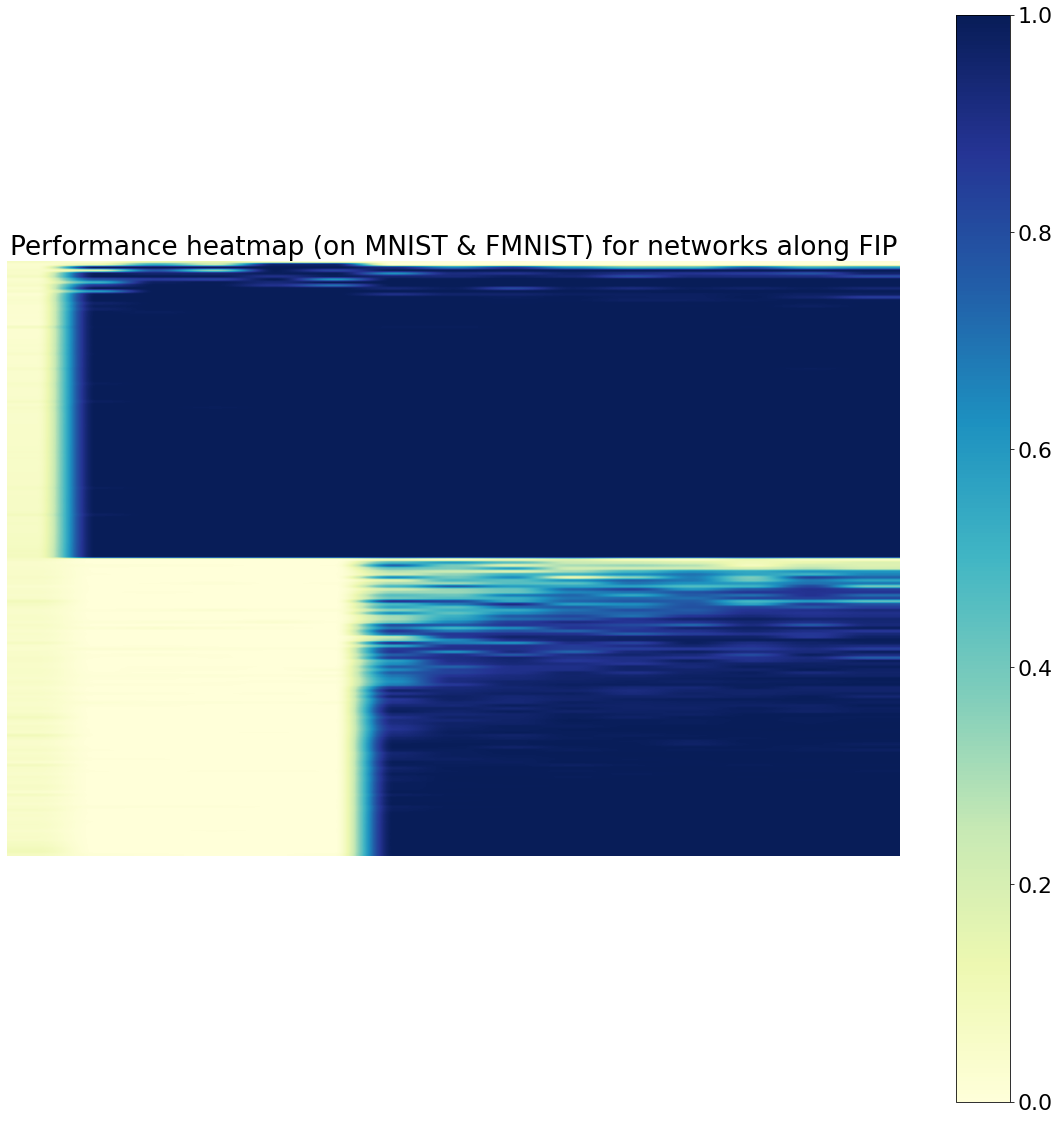

In [65]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from cmcrameri import cm

data = heatmap2
image = np.array(data.T)
nrows, ncols = image.shape

fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(image, cmap='YlGnBu', aspect=0.05)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.05)
#ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.1)

plt.colorbar()
plt.axis('off')
plt.title('Performance heatmap (on MNIST & FMNIST) for networks along FIP')
#plt.savefig('Heatmap_continual_CF_conv.svg', format='svg')
plt.show()

### Plot of accuracy of networks obtained along FIP 
(on MNIST and Fashion-MNIST datasets)

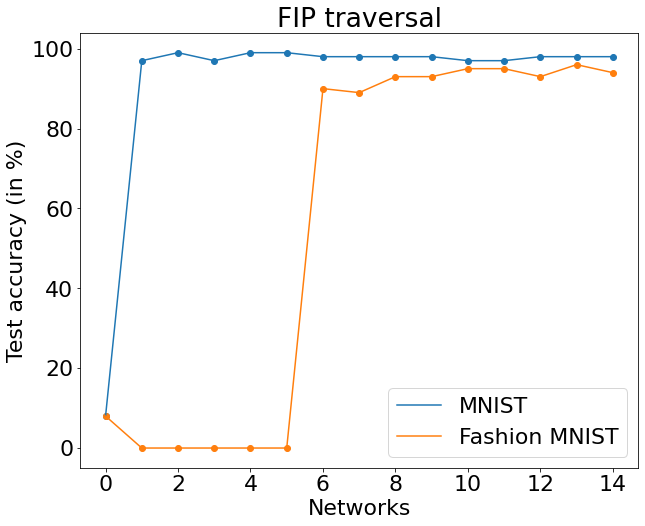

In [70]:
fig = plt.figure(figsize=(10,8))
mnist_acc = np.sum(heatmap_acc[:,mnist_idx],1)/100*100
fmnist_acc = np.sum(heatmap_acc[:,fmnist_idx],1)/100*100

plt.plot(mnist_acc, label="MNIST")
plt.plot(fmnist_acc, label="Fashion MNIST")
plt.scatter(list(range(len(mnist_acc))),mnist_acc)
plt.scatter(list(range(len(fmnist_acc))),fmnist_acc)

plt.title("FIP traversal")
plt.xlabel("Networks")
plt.ylabel("Test accuracy (in %)")
plt.legend()